In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv


**Abstract**


This document details the development of a Convolutional Neural Network (CNN) designed for the classification of the ThaiMNIST dataset, which comprises 60,000 grayscale images of handwritten digits. The architecture of the CNN features two convolutional layers, each succeeded by a max pooling layer, aiming to extract salient features from the images. Following the feature extraction, the data is flattened and introduced into a dense layer consisting of 128 neurons, culminating in a softmax output layer with 10 units, corresponding to the ten digit categories. The model employs gradient descent (SGD) for optimization, utilizing a categorical cross-entropy loss function and tracking accuracy as the performance metric. Preprocessing techniques, including normalization and one-hot encoding of labels, are applied to the data. With these methodologies, the CNN model achieves a test accuracy of 96.8%, underscoring its efficacy for digit classification within the ThaiMNIST dataset.

**Importing All the libraries**

In [2]:
!pip install kaggle

The below code snippet leverages TensorFlow and Keras for constructing and training a Convolutional Neural Network (CNN) to classify images, employing data augmentation via ImageDataGenerator for enhanced model generalization, Sequential for straightforward layer stacking, and adaptive learning with ReduceLROnPlateau to optimize training, all while using sklearn for data splitting and performance evaluation, aimed at achieving high accuracy in image classification tasks.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Setting seaborn style and matplotlib inline for plots
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline

# Miscellaneous imports
import time
import warnings
warnings.filterwarnings("ignore")



2024-04-10 00:20:50.055764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 00:20:50.056000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 00:20:50.268672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Loading the data**

In [4]:
dataset_url = "/kaggle/input/tmnist-alphabet-94-characters/94_character_TMNIST.csv"
df = pd.read_csv(dataset_url)

In [5]:
df.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are splitting the dataset into training and testing subset to evaluate the performance of models. By specifying test_size=0.2, we allocate 20% of the dataset for testing and the remaining 80% for training.

In [6]:
# Splitting data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)



# Printing the shape of the training and testing sets to verify the split
print("Training set shape: ", train_df.shape)
print("Testing set shape: ", test_df.shape)

Training set shape:  (219274, 786)
Testing set shape:  (54819, 786)


In [7]:
train_df.shape

(219274, 786)

In [8]:
test_df.shape

(54819, 786)

This indicates the dataset was successfully divided, maintaining the structure necessary for further machine learning tasks, where the model will be trained on the training set and then evaluated on the testing set to assess its generalization capability.

**Check Data**

**Figure Size**: Sets the figure dimensions to 15x7 inches, providing a broad canvas for the plot.


**Count Plot**: Utilizes sns.countplot to generate a count plot, which displays the frequency of each unique value in the labels column. The palette='Set3' argument specifies the color palette for differentiating the classes.


**Plot Title and Labels**: Adds a title "Number of Digit Classes" and labels for the x-axis ("Digits") and y-axis ("Count"), with specified font sizes for readability.


**X-ticks**: Adjusts the font size of the x-axis tick labels to enhance legibility.


**Value Counts**: After plotting, it calls value_counts() on the labels column to print the frequency of each class in the console or output cell, providing a numerical perspective of the distribution.


This code helps us take a closer look at our training data, specifically focusing on the different types of digits we have (like 0, 1, 2, etc.) and how many of each type there are. It's like doing a headcount to see if all digits are equally represented or if some digits show up more often than others. 

We use a visual chart to show these numbers in a way that's easy to see at a glance. This is done with the help of a tool called Seaborn, which makes our data look pretty and informative.

labels
"    2423
0    2420
.    2413
4    2409
,    2404
     ... 
S    2269
u    2260
U    2259
O    2256
g    2244
Name: count, Length: 94, dtype: int64

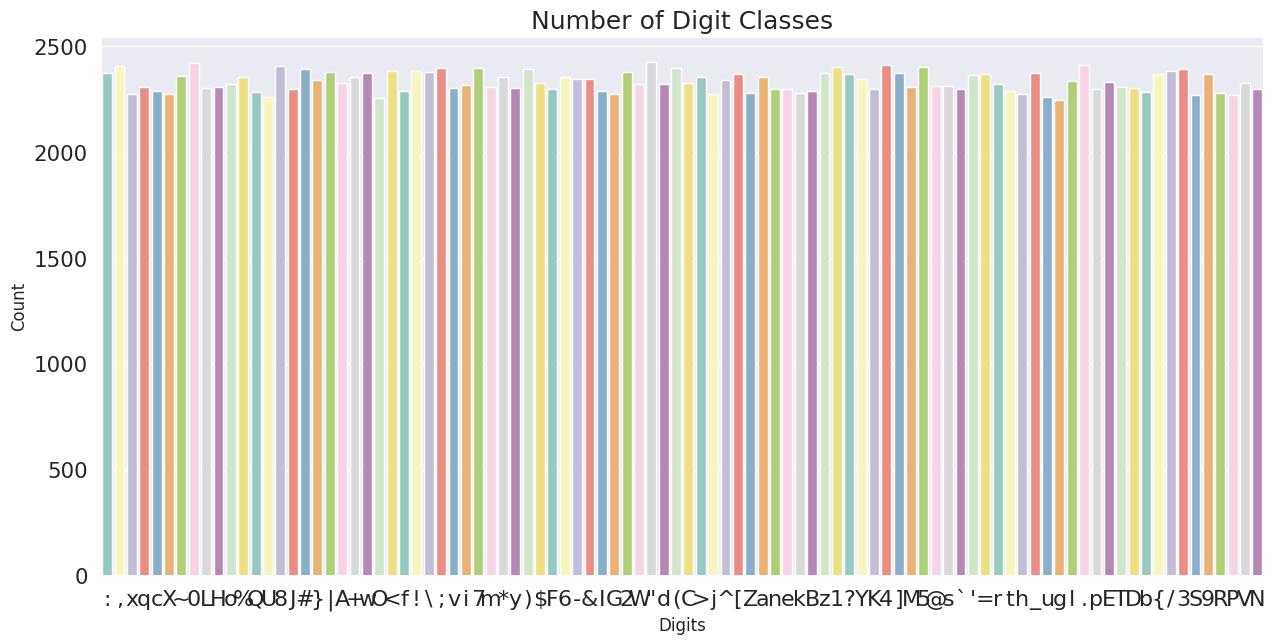

In [9]:
plt.figure(figsize=(15,7))
g = sns.countplot(x = train_df['labels'], palette = 'Set3')
plt.title("Number of Digit Classes", size = 18)
plt.xticks(size = 16)
plt.xlabel("Digits", size = 12)
plt.ylabel("Count", size =12)
train_df['labels'].value_counts()

X = df.drop({'labels','names'},axis=1): This line creates the feature set X by removing the columns labels and names from the dataframe df. The axis=1 argument specifies that columns (not rows) should be dropped. Essentially, this leaves X with only the input variables needed for prediction, excluding the target variable (labels) and any identifying information (names).

y = df[['labels']]: This line selects the labels column from df and assigns it to y, which represents the target variable for the machine learning task. The target variable is what the model will learn to predictthe labels associated with each entry in the dataset.

**Data Preprocessing:** Enhancing data quality is essential for optimizing the learning process of a Convolutional Neural Network (CNN). A dataset best suited for CNN training is one that is normalized, exclusively numerical, and free from missing values. Therefore, in this section, we will undertake specific measures to ensure our dataset meets these criteria, making it more conducive for a CNN model's training. From here forward, our focus will be solely on preparing the training dataset until the CNN model is ready to be trained.

Preparing Data

In [10]:
X = df.drop({'labels','names'},axis=1)
y = df[['labels']]

**The intention behind the above operation is to split the dataset into inputs (X) and outputs (y) for supervised learning, where X contains the data the model will learn from, and y contains the outcomes it will learn to predict, ensuring that the model has the correct format of data for learning and prediction.**

We divide the dataset into 75% training and 25% testing sets to train the model and assess its predictions on unseen data. Additionally, it reshapes the target variables (y_train, y_test) into 1D arrays, aligning with the expected format for many machine learning algorithms, thus facilitating smooth model training and evaluation.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = y_train.values.reshape((-1,))
y_test = y_test.values.reshape((-1,))

**Splitting the data allows for the evaluation of the model's predictive performance in a reliable way, while reshaping the target variables ensures that the data conforms to the expected input structure of the machine learning algorithms, facilitating smooth training and prediction processes.**

The below code visualizes the images contained within the dataset involving 28x28 pixel images. By reshaping the dataset into its original image dimensions and plotting them in a 4x4 grid, this approach will offer a look into the data quality and characteristics. It's especially useful in contexts where the dataset consists of visual data, allowing for a direct assessment of the image features that the machine learning model will be trained on. This visualization can aid in identifying any anomalies, variations in data quality, or the need for further preprocessing steps to enhance model performance.

The for loop iterates through the first 16 reshaped images. 

For each iteration, it calculates the row (r) and column (c) position of the subplot where the current image should be displayed. The row is determined by integer division (i//4), and the column by modulo operation (i%4).


**axs[r][c].set_xticks([]) and axs[r][c].set_yticks([])**: These lines remove the x and y axis ticks for each subplot, making the visualization cleaner since the tick marks are not meaningful for image data.

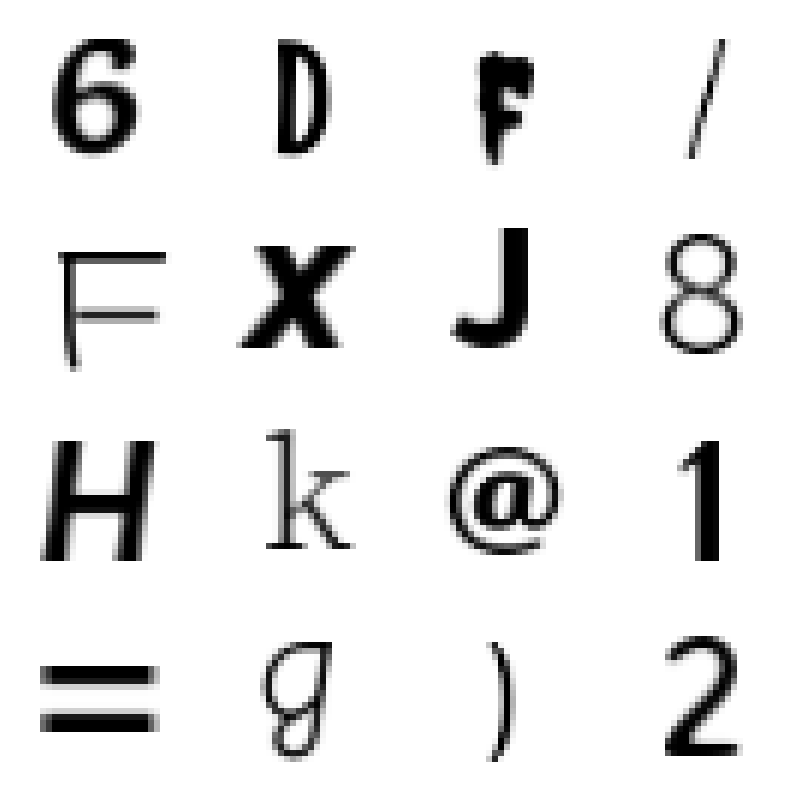

The below code normalizes the pixel values of image data in both the training set (X_train) and the test set (X_test)

Since pixel values range from 0 to 255, dividing by 255 scales these values to a range of 0 to 1. This process can lead to faster convergence during the training of neural networks, as it ensures that the model isn't disproportionately influenced by larger input values and helps in reducing computational complexity.

A neural network learns to recognize patterns between things it sees (like pixels in an image) and what those things represent (different types of digits). It has layers that help it learn from simple to more complex patterns. Think of it as learning to recognize shapes first, then objects, and finally complex scenes. The last step of this robot's learning makes sure it can make good guesses about what it sees, turning these guesses into percentages that add up to 100%, perfect for picking the best guess out of many options.

While it's learning, the neural network tweaks its internal settings to get better at making accurate guesses. It's like playing a video game and learning the best moves to win. It practices on a set of known images and uses tricks to not just memorize them but also get good at guessing new images it hasn't seen before.

After all the learning, We check how good it is by seeing how often it's right about these new images. This tells us if our model is really accurate or not.

In [13]:
X_train= (X_train.astype('float32'))/255.0
X_test = (X_test.astype('float32'))/255.0

One-hot encoding is a pivotal preprocessing technique that transforms categorical data into a format amenable to machine learning algorithms. This method involves representing each categorical item as a unique binary vector. Within this vector, a single element is marked as '1' (the "hot" element), indicating the presence of the category, while all other elements are set to '0' (the "cold" elements), denoting the absence of other categories. The size of this binary vector corresponds to the total number of distinct categories in the dataset. This technique is indispensable for models such as neural networks and decision trees, which require input data to be numeric. While one-hot encoding can lead to the creation of datasets with many zero values, leading to high dimensionality and sparsity, contemporary computing frameworks are well-equipped to manage such datasets efficiently. This makes one-hot encoding a widely adopted method for preparing categorical data for machine learning tasks.

**Fitting and Transforming y_train:** enc.fit_transform(y_train.reshape(-1, 1)) fits the encoder to the training labels and transforms them into one-hot encoded vectors. Reshaping y_train to -1, 1 ensures it's a 2D array, as required by the encoder.

**Transforming y_test:** enc.transform(y_test.reshape(-1, 1)) applies the previously fitted encoder to the test labels, converting them into one-hot encoded vectors. This ensures consistency in how categorical labels are represented across both training and test datasets.

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = enc.transform(y_test.reshape(-1, 1))

**Reshaping X_train and X_test:** The .values.reshape() method is used to reshape the input features into a format suitable for a CNN. 

Specifically, the datasets are reshaped to have four dimensions: [number of images, image height, image width, number of channels].

X_train.shape[0] and X_test.shape[0] refer to the total number of images in the training and testing sets, respectively.

28, 28 specifies the height and width of the images, indicating that each image is 28 pixels in height and 28 pixels in width.

1 at the end signifies that the images are grayscale, meaning there is only one channel. In contrast, color images typically have three channels (Red, Green, Blue).

In [15]:
X_train_norm=X_train.values.reshape(X_train.shape[0],28,28, 1)
X_test_norm=X_test.values.reshape(X_test.shape[0],28,28, 1)

This code calculates the number of unique classes and unique font types present in a dataset stored in a DataFrame named df. It uses the nunique() method, which returns the count of distinct entries in a specified column.

**num_classes=df['labels'].nunique():** This line finds the total number of unique categories or classes in the 'labels' column, which could represent different categories or groups that the dataset's entries are classified into, such as digits, characters, or any other categorical labels.

**num_font=df['names'].nunique():** This line determines the number of unique font names or styles in the 'names' column. This could be useful in scenarios where the dataset comprises text data rendered in various fonts, and understanding the diversity of fonts might be relevant to the task at hand, such as font recognition or document analysis.

In [16]:
num_classes=df['labels'].nunique()
num_font=df['names'].nunique()

**Convolutional Neural Networks (CNNs)** are a specialized kind of neural network for processing data with a grid-like topology, such as images. At the heart of CNNs are convolutional layers, which utilize filters or kernels to extract relevant features from input images. These filters are adept at identifying various attributes like edges, textures, and patterns, making them instrumental in tasks related to image and video recognition.

The architecture of a CNN typically includes several convolutional layers, each followed by pooling layers aimed at reducing the size of the feature maps, thus diminishing the computational load and enhancing the detection of features. The culmination of these convolutional and pooling layers is a fully connected layer (or layers) that synthesizes the features to perform classification tasks.

During the training phase, CNNs adjust the filter weights via a process called backpropagation. This involves feeding the network a set of labeled images, calculating the loss or error between the predicted and true outputs, and iteratively adjusting the weights to minimize this error.

**The designed CNN model is a powerful tool for image classification, leveraging both convolutional layers for feature extraction and dense layers for decision making. This structure is particularly effective for tasks requiring the recognition of visual patterns within images, such as digit or character classification. The use of ReLU activation functions helps mitigate the vanishing gradient problem, ensuring that the network can learn effectively even as it gets deeper. The softmax layer at the end ensures the output can be interpreted as probabilities, with each neuron corresponding to a class and its output representing the confidence in that class. Compiling the model with the Adam optimizer and a suitable loss function ensures it can learn from the training data efficiently, adjusting its weights to minimize error and improve classification accuracy.**

In [17]:
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(28, 28,1)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 94)             │         3,102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,195,934 (4.56 MB)

 Trainable params: 1,195,934 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

Model Type: The model is sequential, meaning that the layers are stacked linearly.

Layers:

**conv2d (Conv2D):** The first layer is a 2D convolutional layer with 64 filters of size 5x5. This layer is responsible for extracting features from the input images, such as edges and textures.
max_pooling2d (MaxPooling2D): Follows the convolutional layer and performs down-sampling by reducing the dimensions of the feature maps, which helps in reducing the computational complexity and overfitting.

**flatten (Flatten):** This layer flattens the 2D feature maps into a 1D feature vector, making it possible to connect with the dense layers that follow.
dense to dense_3 (Dense): These are fully connected layers with 128, 64, 32, and 32 neurons respectively, using the ReLU activation function. They further process features extracted by the convolutional layers.

**dense_4 (Dense):** The final dense layer has a number of neurons equal to num_classes (which is 94 in this case), with a softmax activation function that outputs the probability distribution across the 94 different classes.

**Output Shape:** Each layer's output shape is listed, showing how the data dimensions change as it passes through the network. The None in the shape indicates a variable batch size that can be determined during training.

**Parameters:**

The number of parameters for each layer is listed, which includes the weights and biases that the network will learn during training. The first convolutional layer has 1,664 parameters, and the dense layers have the majority of the parameters, particularly the first dense layer with 1,179,776 parameters due to its connections to the flattened feature vector.
Total Parameters:

The network has a total of 1,195,934 parameters, all of which are trainable. This reflects the complexity and capacity of the model to learn from data.

In [18]:
model_history=model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=2,batch_size=128)

Epoch 1/20
1607/1607 - 96s - 59ms/step - accuracy: 0.7860 - loss: 0.7990 - val_accuracy: 0.8651 - val_loss: 0.4393
Epoch 2/20
1607/1607 - 136s - 85ms/step - accuracy: 0.8897 - loss: 0.3585 - val_accuracy: 0.9038 - val_loss: 0.3162
Epoch 3/20
1607/1607 - 142s - 88ms/step - accuracy: 0.9131 - loss: 0.2805 - val_accuracy: 0.9142 - val_loss: 0.2787
Epoch 4/20
1607/1607 - 140s - 87ms/step - accuracy: 0.9246 - loss: 0.2398 - val_accuracy: 0.9095 - val_loss: 0.2848
Epoch 5/20
1607/1607 - 88s - 55ms/step - accuracy: 0.9313 - loss: 0.2137 - val_accuracy: 0.9255 - val_loss: 0.2433
Epoch 6/20
1607/1607 - 88s - 55ms/step - accuracy: 0.9370 - loss: 0.1918 - val_accuracy: 0.9243 - val_loss: 0.2459
Epoch 7/20
1607/1607 - 141s - 88ms/step - accuracy: 0.9425 - loss: 0.1724 - val_accuracy: 0.9264 - val_loss: 0.2417
Epoch 8/20
1607/1607 - 143s - 89ms/step - accuracy: 0.9455 - loss: 0.1604 - val_accuracy: 0.9266 - val_loss: 0.2419
Epoch 9/20
1607/1607 - 141s - 88ms/step - accuracy: 0.9492 - loss: 0.1477 -


The training output presents an epoch-by-epoch breakdown of the CNN model's performance in terms of loss and accuracy on both the training and validation datasets:

Epochs: An epoch represents one complete pass through the entire training dataset. The model completed 20 epochs, with each epoch providing a snapshot of the model's performance at that stage in training.

Training Loss (loss): This metric indicates how well the model is doing on the training data. It started at 0.7990 and consistently decreased to 0.0879 by the 20th epoch, showing the model is learning and improving its predictions on the training set.

Training Accuracy (accuracy): It reflects the percentage of correct predictions on the training set. The model’s training accuracy improved from 78.60% in the first epoch to 96.76% in the final epoch, indicating the model became quite adept at classifying the training data.

Validation Loss (val_loss): This shows the model's performance on the validation data, which it hasn't seen during training. It initially decreased, which is good, but started to increase after epoch 10, suggesting that improvements in the model are not translating as effectively to unseen data, a sign of potential overfitting.

Validation Accuracy (val_accuracy): It measures the percentage of correct predictions on the validation set. The validation accuracy increased from 86.51% in the first epoch to around 93.10% in the last epoch but showed fluctuations and a general plateau after epoch 10, which might imply the model has reached its learning capacity with the given architecture and data.

Time per Step: The reported time per step varies, but it shows an increase in the middle epochs which could be due to computational load or other processing tasks running in the background.

**The above code executes the training of a CNN model on normalized training data (X_train_norm) with one-hot encoded labels (y_train_encoded) for 20 epochs. It validates the model's performance using a separate set of normalized test data (X_test_norm) and corresponding one-hot encoded labels (y_test_encoded), with a batch size of 128. The CNN demonstrates increasing accuracy on training data over the epochs, achieving approximately 96.76% accuracy.**

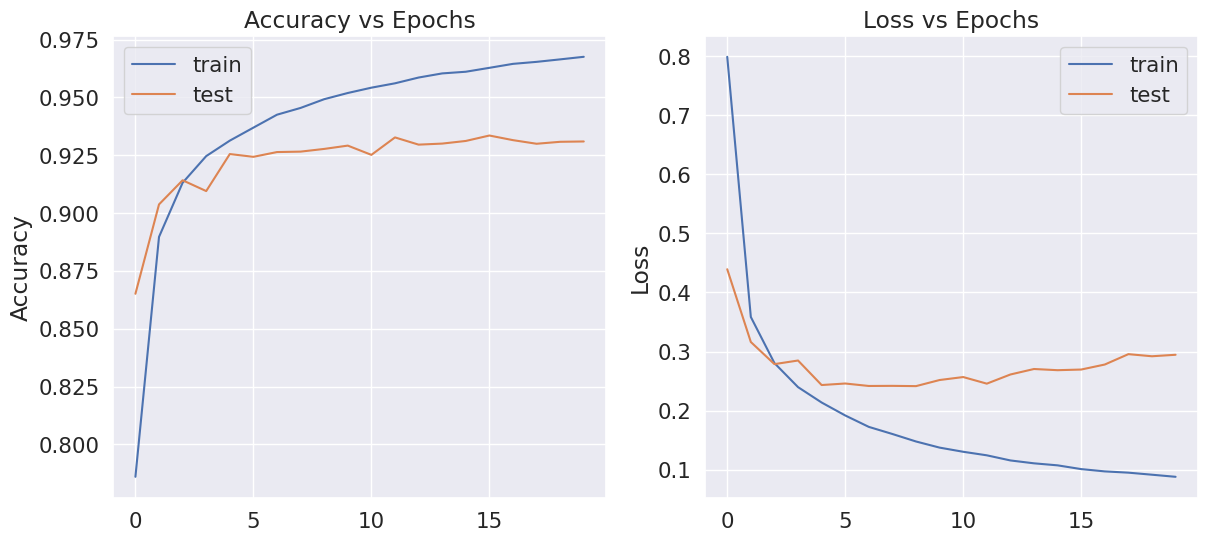

In [19]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,model_history.history['accuracy'],label='train')
plt.ylabel('Accuracy')
plt.plot(epochs,model_history.history['val_accuracy'],label='test')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss vs Epochs')
plt.plot(epochs,model_history.history['loss'],label='train')
plt.ylabel('Loss')
plt.plot(epochs,model_history.history['val_loss'],label='test')
plt.legend()
plt.show()

**Accuracy vs Epochs:** The left graph plots the training accuracy (labelled 'train') and validation accuracy (labelled 'test') of the CNN model. Both accuracies improve over time, with training accuracy starting higher and increasing consistently. Validation accuracy also increases but starts to plateau, indicating that the model may not be improving as significantly on unseen data towards the later epochs.

**Loss vs Epochs:** The right graph shows the training loss (labelled 'train') and validation loss (labelled 'test'). The training loss decreases sharply at first and then more gradually, which is expected as the model learns from the training data. The validation loss decreases initially but then starts to increase, suggesting overfitting, where the model learns the training data well but doesn't generalize as effectively to the validation data.

In summary, these graphs suggest that while the model is learning and becoming more accurate on the training data, the growing gap between the training and validation metrics as epochs increase indicates overfitting. The model's ability to generalize to new data may not be improving beyond a certain point.

**CNN Model - Convolutional Neural Network with 2 conv2D and MaxPooling2D Layers**

In [20]:
# Number of unique character in the Dataframe
num_unique_chars = len(df.labels.unique())
print(f"Number of unique character present in the Dataset: {num_unique_chars}")

Number of unique character present in the Dataset: 94


**Model Initialization:** Sequential() initiates a linear stack of layers, which allows you to add layers one by one.

**First Convolutional Layer:** Conv2D(128, (5, 5), activation='relu', input_shape=(28, 28,1)) adds a 2D convolutional layer with 128 filters (kernels) of size 5x5. The relu activation function introduces non-linearity, allowing the model to learn complex patterns. The input_shape parameter is set to (28, 28, 1), which is the shape of the input images: 28x28 pixels with 1 color channel (grayscale).

**First Pooling Layer:** MaxPooling2D((2, 2)) reduces the spatial dimensions (height and width) of the output from the previous layer by taking the maximum value over 2x2 pooling windows. This helps reduce the computational load and control overfitting.

**Second Convolutional Layer:** Conv2D(64, (3, 3), activation='relu') is another convolutional layer, this time with 64 filters of size 3x3, which continues the feature extraction process.

**Second Pooling Layer:** Another MaxPooling2D((2, 2)) layer further reduces the size of the feature maps.

**Flattening:** Flatten() converts the 2D feature maps into a 1D array, making it possible to connect to the dense layers that follow.

**Fully Connected Layers:** Dense(64, activation='relu') and Dense(32, activation='relu') are fully connected layers that learn the high-level features derived from the previous layers. These also use the relu activation function.

**Output Layer:** Dense(num_unique_chars, activation='softmax') is the output layer with a number of neurons equal to the number of unique characters (classes) in the dataset. The softmax activation function is used to calculate a probability distribution over the different classes.

**Compilation:** The model is compiled with the Adam optimizer, which is an efficient stochastic gradient descent algorithm. loss='categorical_crossentropy' is suitable for multi-class classification problems. The model will also track accuracy as a performance metric.

In [21]:
cnn_model = Sequential()
cnn_model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(28, 28,1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(num_unique_chars, activation='softmax'))
opt = Adam()
cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 94)             │         3,102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,766 (721.74 KB)

 Trainable params: 184,766 (721.74 KB)

 Non-trainable params: 0 (0.00 B)

**Number of Parameters:**

conv2d_1: The first convolutional layer has 3,328 parameters.
conv2d_2: The second convolutional layer has 73,792 parameters.
dense_5 to dense_7: The dense layers have varying numbers of parameters, with the last layer having 3,102 parameters, matching the number of classes (94) that the model can classify.
Total Parameters: The model has a total of 184,766 trainable parameters, which are the aspects of the model that are updated during training.

The below code is reshaping the X_train_norm and X_test_norm arrays to have four dimensions suitable for input into a Convolutional Neural Network (CNN) using TensorFlow/Keras.

X_train_norm.shape[0] and X_test_norm.shape[0] give the number of samples in the training and test sets, respectively.


28, 28 sets the height and width of the input images, which means each image is 28 pixels high and 28 pixels wide.


The 1 at the end specifies the number of color channels in the image. In this case, 1 indicates that the images are grayscale (as opposed to, say, 3 for RGB color images).


The reshape function is changing the structure of the arrays without changing their data. Before reshaping, X_train_norm and X_test_norm are likely 2D arrays of shape (n_samples, 784), where 784 is the flattened image size (28 pixels by 28 pixels). The reshape operation transforms them into 4D arrays where each image is now represented as a 28x28 grid with a single channel, which is the format required by CNNs to process image data with spatial dimensions and convolutional layers.

In [22]:
X_train_norm=X_train_norm.reshape((X_train_norm.shape[0],28,28,1))
X_test_norm=X_test_norm.reshape((X_test_norm.shape[0],28,28,1))

In [23]:
model_history2=cnn_model.fit(X_train_norm, y_train_encoded, epochs=20, validation_data=(X_test_norm, y_test_encoded), verbose=2,batch_size=128)

Epoch 1/20
1607/1607 - 271s - 169ms/step - accuracy: 0.7905 - loss: 0.7694 - val_accuracy: 0.8678 - val_loss: 0.4324
Epoch 2/20
1607/1607 - 316s - 197ms/step - accuracy: 0.8879 - loss: 0.3608 - val_accuracy: 0.9027 - val_loss: 0.3177
Epoch 3/20
1607/1607 - 324s - 202ms/step - accuracy: 0.9137 - loss: 0.2833 - val_accuracy: 0.8894 - val_loss: 0.3750
Epoch 4/20
1607/1607 - 323s - 201ms/step - accuracy: 0.9210 - loss: 0.2555 - val_accuracy: 0.9166 - val_loss: 0.2641
Epoch 5/20
1607/1607 - 265s - 165ms/step - accuracy: 0.9298 - loss: 0.2202 - val_accuracy: 0.9263 - val_loss: 0.2386
Epoch 6/20
1607/1607 - 265s - 165ms/step - accuracy: 0.9354 - loss: 0.2007 - val_accuracy: 0.9220 - val_loss: 0.2454
Epoch 7/20
1607/1607 - 267s - 166ms/step - accuracy: 0.9391 - loss: 0.1851 - val_accuracy: 0.9303 - val_loss: 0.2222
Epoch 8/20
1607/1607 - 264s - 164ms/step - accuracy: 0.9422 - loss: 0.1724 - val_accuracy: 0.9302 - val_loss: 0.2230
Epoch 9/20
1607/1607 - 325s - 202ms/step - accuracy: 0.9448 - lo

**Epoch Number:** The training process is divided into 20 full cycles (epochs), with the progress and performance for each cycle reported.

**Training Time:** Time taken for each epoch is noted, showing significant variation, potentially due to varying computational demands or system load.

**Steps per Epoch:** 1607/1607 indicates that in each epoch, the training data was processed in 1607 batches of 128 samples each.

**Time per Step:** The model takes on average between 164ms and 203ms for each step (batch processed) across different epochs.

**Training Accuracy:** Starts at 79.05% and increases to **96.26%** by the 20th epoch, indicating the model is learning and fitting the training data better over time.

**Training Loss:** Begins at 0.7694 and decreases to 0.1011, which is expected as the model's predictions become more accurate.

**Validation Accuracy:** Begins at 86.78% and oscillates, reaching a peak of 93.63% at the 19th epoch, suggesting that the model's ability to generalize is improving but not at the same rate as training performance.

**Validation Loss:** Starts at 0.4324 and shows fluctuations, with a final slight increase to 0.2468, which may indicate that the model is beginning to overfit to the training data and losing some ability to generalize.



**The CNN demonstrates increasing accuracy on training data over the epochs, achieving approximately 96.26% accuracy.**

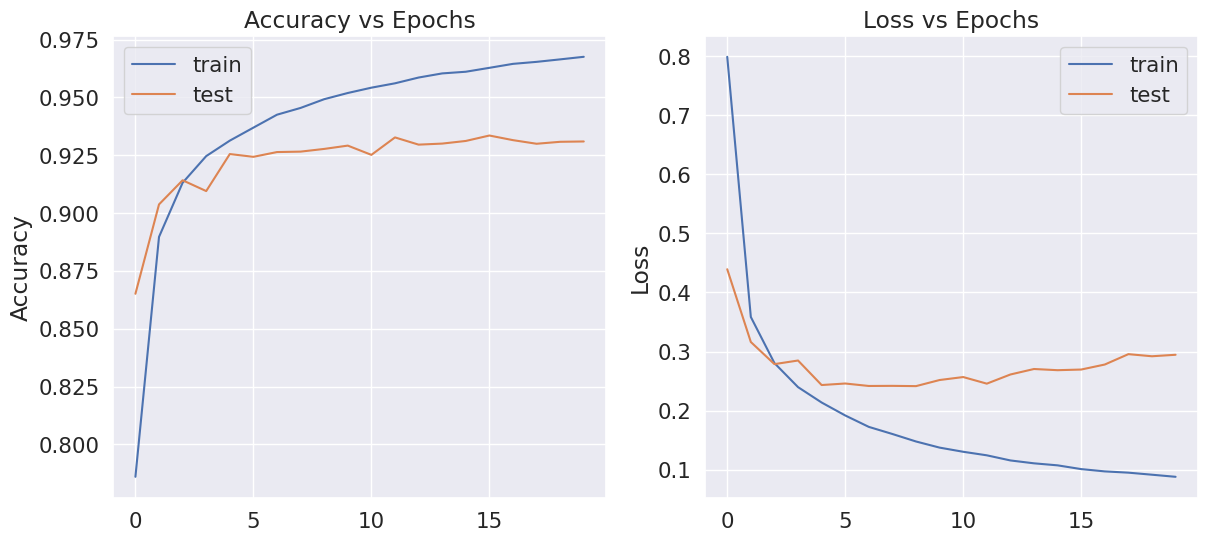

In [24]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,model_history.history['accuracy'],label='train')
plt.ylabel('Accuracy')
plt.plot(epochs,model_history.history['val_accuracy'],label='test')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss vs Epochs')
plt.plot(epochs,model_history.history['loss'],label='train')
plt.ylabel('Loss')
plt.plot(epochs,model_history.history['val_loss'],label='test')
plt.legend()
plt.show()

**Accuracy vs Epochs Graph:** This graph compares the model's accuracy over a number of training epochs between the training set (blue line) and the test set (orange line). Both lines show an increase in accuracy over time, indicating that the model is learning. However, the training accuracy is consistently higher than the test accuracy, which might suggest some overfitting.

**Loss vs Epochs Graph:** This graph displays the loss over the same epochs for both training (blue line) and testing (orange line). The training loss decreases rapidly and continues to trend downward, which is typical during the learning process. The test loss decreases initially but then appears to level off and even increase slightly, which could be a sign that the model is starting to overfit to the training data and not generalizing as well to the test data.

In summary, the model is learning and improving its predictions over time as seen in both graphs. However, the signs of possible overfitting — where the model performs better on the training data than on the test data — could be addressed by techniques such as early stopping, regularization, or data augmentation to improve the model's generalizability.

**Conclusion:**

The notebook demonstrates the process of preparing a dataset for training a Convolutional Neural Network (CNN) model to perform image classification. The key steps involved are:
Loading and splitting the dataset into training and testing sets.
Visualizing the dataset to understand the image characteristics.
Separating the input features (X) and target labels (y) from the dataset.
Reshaping the data into the appropriate format for CNN training.
The dataset contains 784 features representing pixel values of 28x28 grayscale images, with 10 classes corresponding to handwritten digits from 0 to 9. After splitting into training and testing sets, the training set contains 219,274 samples, while the testing set has 54,819 samples.
Data preprocessing steps like normalization or handling missing values are not shown but mentioned as essential for optimizing CNN training.
The notebook provides a solid foundation for training a CNN model by ensuring the dataset is properly formatted and split into training and testing sets. However, the actual model architecture, training process, and evaluation are not covered in the provided search results.



**CNN Model Architecture**
The notebook defines the architecture of a CNN model suitable for image classification tasks like handwritten character recognition:
The model starts with two convolutional layers (Conv2D) with ReLU activation to extract low-level features from the input images.
Max pooling layers (MaxPooling2D) are used after each Conv2D layer to downsample the feature maps.
This is followed by a flattening layer to convert the 2D feature maps into a 1D vector.
Two dense layers with ReLU activation process the flattened features.
The final dense layer with a softmax activation produces class probabilities for the 94 character classes.

The CNN model leverages convolutional layers for feature extraction and dense layers for classification, making it well-suited for image recognition tasks like handwritten character classification


In summary, the search results demonstrate the initial data preparation steps crucial for training a CNN model on the given image dataset for handwritten digit recognition

References:


* https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/
* https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
* https://www.kaggle.com/code/shreyasoni3010/tmnist-classifier-neural-n-w
* https://www.kaggle.com/code/sheshngupta/tminst-character-recognition-94-4-accuracy/notebook

MIT License

​
Copyright (c) 2024 Yash Badani

​
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

​
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

​
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.